### Imports

In [15]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# regression imports
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

# Survival curve imports\
#!pip install lifelines
from lifelines import KaplanMeierFitter

# google imports
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Data

In [16]:
# loading in dataframe
df = pd.read_csv('/content/drive/MyDrive/DS Capstone/Mini Projects/cleaned_capo_data.csv')
df.head()

# need to create the tcs column

,dem_age,dem_sex,dem_pregnant,dem_trimester,exam_height,exam_weight,exam_hr,exam_rr,exam_sbp,exam_dbp,...,lab_crp,lab_pct,lab_vitamind,lab_abg,lab_abgph,lab_abgpaco2,lab_abgpao2,lab_abgbicarb,lab_abgfio2,TCS
0,54.0,1.0,0.026528,2.157895,175.000000,98.00000,100.0,20.0,120.0,63.000000,...,73.892146,6.48213,34.64,0.515819,7.434445,35.962724,67.068697,23.99043,24.278867,3
1,64.0,1.0,0.026528,2.157895,158.603831,72.54643,150.0,30.0,130.0,80.000000,...,73.892146,6.48213,34.64,1.000000,7.434445,35.000000,64.000000,22.00000,21.000000,8
2,92.0,1.0,0.026528,2.157895,158.603831,72.54643,76.0,14.0,118.0,72.046101,...,73.892146,6.48213,34.64,1.000000,7.434445,38.200000,67.068697,22.80000,24.278867,8
3,60.0,1.0,0.026528,2.157895,178.000000,101.00000,104.0,22.0,150.0,78.000000,...,73.892146,6.48213,34.64,1.000000,7.434445,35.962724,67.068697,23.99043,24.278867,2
4,64.0,1.0,0.026528,2.157895,185.000000,68.00000,98.0,22.0,134.0,53.000000,...,73.892146,6.48213,34.64,1.000000,7.434445,29.800000,67.068697,20.90000,24.278867,3


### Creating Survival Curve

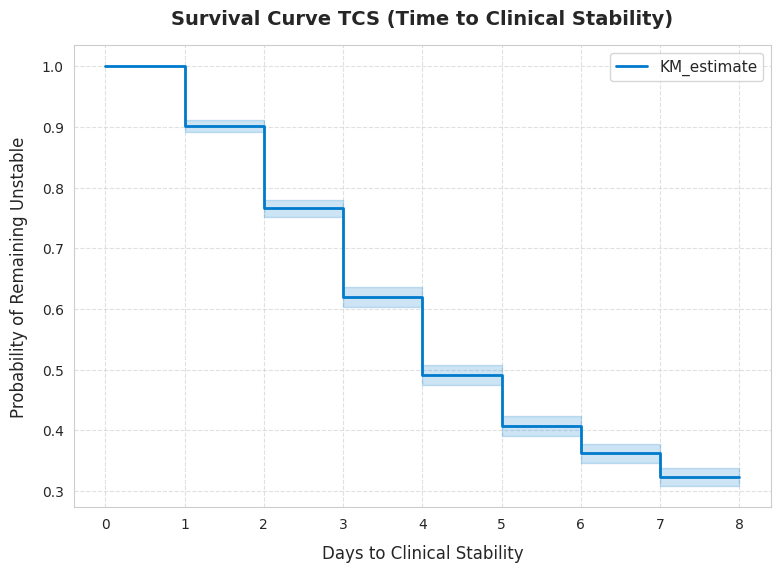

In [17]:
# survival curve

# Create new model
df_survival = df.copy()

# Define event occurrence: 1 if patient stabilized before day 8, 0 if censored
df_survival['event_occurred'] = (df_survival['TCS'] != 8).astype(int)

# Check the DataFrame structure
#print(df_survival.head())

# Initialize Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Fit the model
kmf.fit(durations=df_survival['TCS'], event_observed=df_survival['event_occurred'])

# Apply Seaborn style
sns.set_style("whitegrid")

# Create figure and axis
plt.figure(figsize=(9, 6))

# Plot survival function with confidence intervals
kmf.plot_survival_function(ci_show=True, ci_alpha=0.2, linewidth=2, color="#007acc")

# Customize the plot
plt.title("Survival Curve TCS (Time to Clinical Stability)", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Days to Clinical Stability", fontsize=12, labelpad=10)
plt.ylabel("Probability of Remaining Unstable", fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)


# Add a legend
plt.legend(fontsize=11, loc="best")

# Show plot
plt.show()

### Building Linear Regression Model

In [18]:
"""
Use the demographic, examination, and chest x-ray data to build a linear regression model to
predict time to clinical stability. Evaluate the model using the R2 value
"""

# creating lm data frame

# getting columns
df.columns
# saving into a variable
ln_prediction_columns = ['dem_age', 'dem_sex', 'dem_pregnant', 'dem_trimester', 'exam_height',
       'exam_weight', 'exam_hr', 'exam_rr', 'exam_sbp', 'exam_dbp',
       'exam_temp', 'exam_o2sat', 'exam_o2satvalue', 'exam_fio2',
       'exam_mental', 'cx_rul', 'cx_rml', 'cx_rll', 'cx_lul', 'cx_lll',
       'cx_db', 'cx_du', 'cx_cav', 'cx_pe','TCS']
# creating columns
lm_df = df[ln_prediction_columns]
# validating df creation
lm_df.head()

# create and train linear regression model

# splitting data into training and test data

# creating X & Y
X = lm_df.drop('TCS', axis=1)
y = lm_df['TCS']

# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fitting model

lm = LinearRegression()

lm.fit(X_train,y_train)

# creating prediction variable

y_pred = lm.predict(X_test)

# evaluating model

r2 = r2_score(y_test, y_pred)

#displaying results
print(r2)


# with an R^2 value of 0.053, this model is incredible inaccurate and is not useful for predictions

0.053480936160988146


### Building Logistic Regression Models

In [19]:
# Creating stable/not stable values
# 1 - stable, 0 - not stable
df['stable'] = (df['TCS'] != 8).astype(int)

# Creating TCS/ late TCS value
# 1 - Late TCS, 0 - TCS
df['Late_TCS'] = (df['TCS'] >= 4).astype(int)

# creating log model data

log_prediction_columns = ln_prediction_columns + ['stable', 'Late_TCS']

log_df = df[log_prediction_columns]

# creating x and y variables for stable
x_stable = log_df.drop(['stable', 'Late_TCS'], axis=1)
y_stable = log_df['stable']

# creating x and y for Late_TCS
x_late = log_df.drop(['stable', 'Late_TCS'], axis=1)
y_late = log_df['Late_TCS']

# splitting both groups into training and testing data
#stable
X_train_stable, X_test_stable, y_train_stable, y_test_stable = train_test_split(x_stable, y_stable, test_size=0.2, random_state=42)
# Late_TCS
X_train_Late, X_test_Late, y_train_Late, y_test_Late = train_test_split(x_late, y_late, test_size=0.2, random_state=42)

# creating logistic regression model

logmodel = LogisticRegression(max_iter=3000)

# stable
logmodel.fit(X_train_stable,y_train_stable)

# Late_TCS
logmodel.fit(X_train_Late,y_train_Late)

# creating prediction variables

y_pred_stable = logmodel.predict(X_test_stable)
y_pred_late = logmodel.predict(X_test_Late)

# Showing R^2 for both groups
#stable
r2_stable = r2_score(y_test_stable, y_pred_stable)
#late
r2_late = r2_score(y_test_Late, y_pred_late)

print('Stable or not stable R^2 score: ' + str(r2_stable))
print('TCS early or late R^2 Score: ' + str(r2_late))

# When predicting if the model would be good at predictingn if the patient would be stable
# the R^2 was horrible and was much worse than just taking the averages of the means

# When looking at the TCS early or late the R^2 was 1 meaning that it was a perfect fit for the data


Stable or not stable R^2 score: -2.2683564446465105
TCS early or late R^2 Score: 1.0


### Building Logistic Models with Lab Data

In [25]:
# Obtaining Lab Data
lab_df = df.copy()

lab_columns = ['lab_hematocrit', 'lab_hemoglobin', 'lab_wbc',
       'lab_bands', 'lab_platelets', 'lab_inr', 'lab_na', 'lab_k', 'lab_bun',
       'lab_creatinine', 'lab_bicarb', 'lab_glucose', 'lab_albumin', 'lab_ast',
       'lab_alt', 'lab_bilirubin', 'lab_trop1', 'lab_trop2', 'lab_trop3',
       'lab_ckmb1', 'lab_ckmb2', 'lab_ckmb3', 'lab_ldl', 'lab_hdl',
       'lab_cholesterol', 'lab_triglycerides', 'lab_lactate', 'lab_hga1c',
       'lab_ldh', 'lab_bnp', 'lab_crp', 'lab_pct', 'lab_vitamind', 'lab_abg',
       'lab_abgph', 'lab_abgpaco2', 'lab_abgpao2', 'lab_abgbicarb',
       'lab_abgfio2']

lab_df = lab_df[lab_columns]

#validation check
lab_df.head()

# Re-running the logistic models to see if adding the lab data improves results

# creating log model data

log_prediction_columns = ln_prediction_columns + ['stable', 'Late_TCS'] + lab_columns

log_df = df[log_prediction_columns]

# creating x and y variables for stable
x_stable = log_df.drop(['stable', 'Late_TCS'], axis=1)
y_stable = log_df['stable']

# creating x and y for Late_TCS
x_late = log_df.drop(['stable', 'Late_TCS'], axis=1)
y_late = log_df['Late_TCS']

# splitting both groups into training and testing data
#stable
X_train_stable, X_test_stable, y_train_stable, y_test_stable = train_test_split(x_stable, y_stable, test_size=0.2, random_state=42)
# Late_TCS
X_train_Late, X_test_Late, y_train_Late, y_test_Late = train_test_split(x_late, y_late, test_size=0.2, random_state=42)

# creating logistic regression model

logmodel = LogisticRegression(max_iter=10000)

# stable
logmodel.fit(X_train_stable,y_train_stable)

# Late_TCS
logmodel.fit(X_train_Late,y_train_Late)

# creating prediction variables

y_pred_stable = logmodel.predict(X_test_stable)
y_pred_late = logmodel.predict(X_test_Late)

# Showing R^2 for both groups
#stable
r2_stable = r2_score(y_test_stable, y_pred_stable)
#late
r2_late = r2_score(y_test_Late, y_pred_late)

print('Stable or not stable R^2 score: ' + str(r2_stable))
print('TCS early or late R^2 Score: ' + str(r2_late))

# Compared to before the lab results were used, stable saw no signifigant differance
# and tcs early or late saw a slight decrease in acurracy but still overall remaning relatively high

Stable or not stable R^2 score: -2.261631431385921
TCS early or late R^2 Score: 0.9821703609455569
